# Introduction

This Notebook shows how to make a deep learning Model for generating caption for any given image. The model will have three parts:

**Image Feature Extractor** - 16 layer VGG model which is pretrained on ImageNet dataset. We will remove the outer 2 dense layer from the architecture and will use the feature extractor part of VGG to preprocess our image dataset.

**Caption Processor** - This model will have one embedding layer with LSTM to process our captions text.

**Image_Caption_Combination** - We will prepare the input dictionary to feed to the final model by mapping the image and text.

**Final Model** - This is the final model in which we input the image features extracted by the "Image Feature Extractor" and text features extracted by the "Caption Processor" and train it to generate captions for any given image.

We will go step by step in training the model from worst to best. 


# Data Preparation

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [5]:
image_dataset_path = '../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset'
caption_dataset_path = '../input/flickr8k-imageswithcaptions/Flickr8k_text/Flickr8k.token.txt'

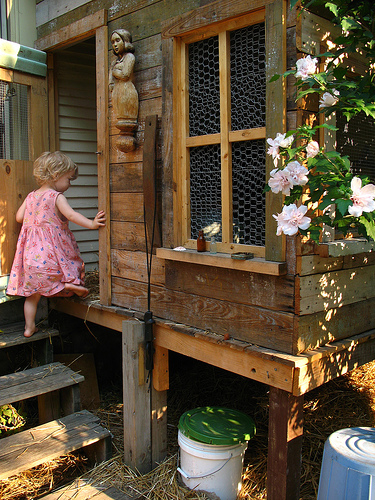

In [3]:
from IPython.display import Image
Image('../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

# Caption Processor

In [6]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

# Preprocess the captions



1) Convert the captions into lowercase

2) Tokenize the captions into different tokens

3) Remove all the punctuations from the tokens

4) add "start_index" and "end_index" as pointers to tell the model start of the caption and end of the caption

In [7]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'
    

In [8]:
# delete unwanted 
del captions_dict

In [9]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [10]:
len(new_captions_dict)

8092

## Make a list of only those images who has caption

In [11]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [12]:
caption_images_list[0]

'2100735137_05c6079537'

In [13]:
len(caption_images_list)

8091

# Make training, validation and test data

### taking 7081 images for training, 1000 for validation and rest 10 for testing

In [14]:
train_validate_images = caption_images_list[0:8081]  

In [15]:
test_images = caption_images_list[8081:8091]
test_images

['3366904106_e996320d20',
 '2739331794_4ae78f69a0',
 '2760715910_87c7bdeb87',
 '2647049174_0fb47cee2e',
 '3256043809_47258e0b3e',
 '2332986053_864db84971',
 '3443161359_65544fd732',
 '2414384480_096867d695',
 '2880051254_e0ca96b6be',
 '1459032057_97e73ed6ab']

# Image Feature Extractor

**extract_features** function extracts the important features out of the images passed using VGG16 model.

In [14]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

## ALERT: Following piece of code takes time 

In [15]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

553467904/553467096 [==============================] - 9s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

In [16]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

2100735137_05c6079537 : [[3.3024292  2.5687056  0.49229822 ... 0.         4.5804315  2.6672919 ]]


In [17]:
len(train_validate_features)

8081

In [18]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

## Preparing the input data

Each caption will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained. So we will have two features, x1 (image) , x2 (text_sequence) and one target variable, y (generated_word).

Image,		   text sequence, 						generated_word

photo	         startseq, 									little

photo	       startseq, little,							girl

photo	       startseq, little, girl, 					running

photo	       startseq, little, girl, running, 			in

photo	       startseq, little, girl, running, in, 		field

photo	       startseq, little, girl, running, in, field, endseq

In [21]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

### make sure the correct caption is mapped with the correct image

In [21]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

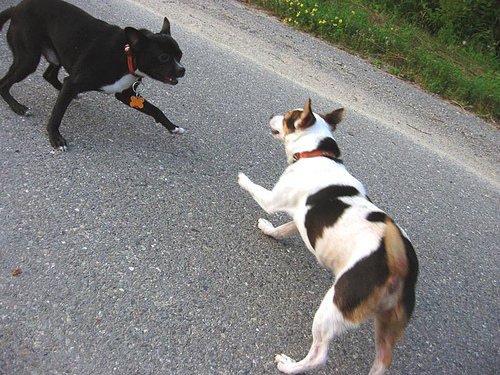

In [22]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [ ]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [24]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [25]:
len(train_x1)

72378

In [26]:
len(validate_x1)

10155

# Final Model

## Model architecture

In [32]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 256)      1148672     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_4[0][0]                    
_______________________________________________________________________________________

## Plot the model architecture

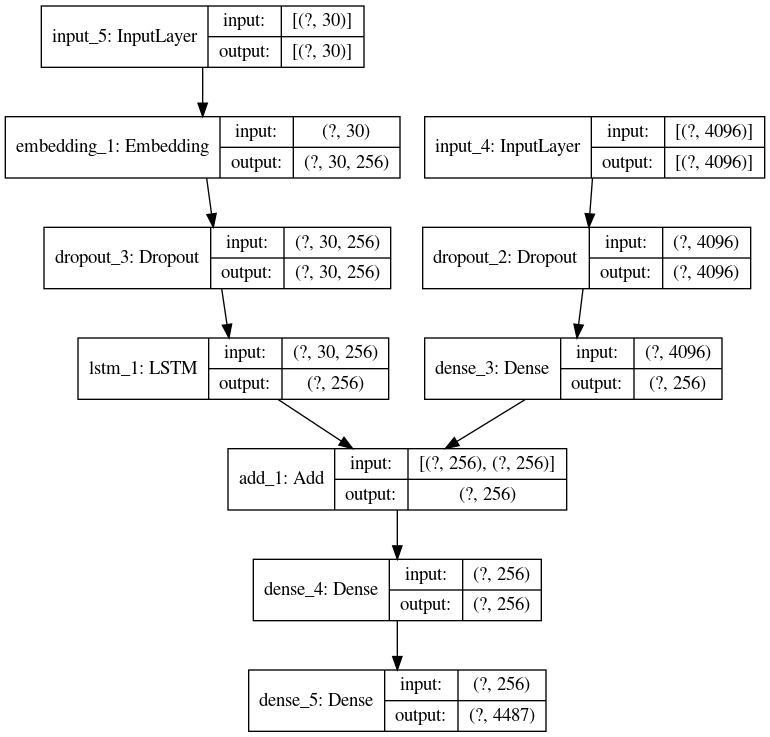

In [33]:
plot_model(model, to_file='model.png', show_shapes=True)

## Reducing Overfitting

In [34]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]


### Make sure feature data and target data share the same first dimension

In [35]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72378, 4096)
shape of train_x2  (72378, 30)
shape of train_y  (72378, 4487)

shape of validate_x1  (10155, 4096)
shape of validate_x2  (10155, 30)
shape of validate_y  (10155, 4487)


## Train the model using training data and validation data

# Training Model - Part 1 

In [36]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y)) 

Epoch 1/20
2262/2262 [==============================] - 225s 100ms/step - loss: 5.0835 - val_loss: 4.5037
Epoch 2/20
2262/2262 [==============================] - 224s 99ms/step - loss: 4.2097 - val_loss: 4.2868
Epoch 3/20
2262/2262 [==============================] - 205s 90ms/step - loss: 3.8594 - val_loss: 4.2351
Epoch 4/20
2262/2262 [==============================] - 200s 88ms/step - loss: 3.6346 - val_loss: 4.2607
Epoch 5/20
2262/2262 [==============================] - 199s 88ms/step - loss: 3.4618 - val_loss: 4.3184
Epoch 6/20
2262/2262 [==============================] - 198s 87ms/step - loss: 3.3198 - val_loss: 4.4102
Epoch 7/20
2262/2262 [==============================] - 201s 89ms/step - loss: 3.2017 - val_loss: 4.5536
Epoch 8/20
2262/2262 [==============================] - 198s 88ms/step - loss: 3.0943 - val_loss: 4.6464
Epoch 9/20
2262/2262 [==============================] - 200s 88ms/step - loss: 2.9956 - val_loss: 4.8162
Epoch 10/20
2262/2262 [==============================]

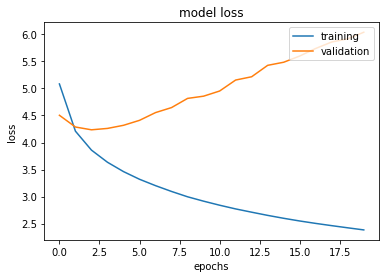

In [37]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [38]:
# saving the model with last parameter 
model.save('./latest_model.h5')

# Evaluate the model  - Part 1

In [16]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None
 

In [17]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

## Evaluating model on training images using the latest model

Latest model has training loss 2.38 and validation loss as 6.04, i.e. it has overfitted so we can expect that it will perform better on the training images than the test images

In [23]:
from keras.models import load_model
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 34

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq boy in red shirt is running in the grass endseq

Actual caption ->  startseq little boy jumps on toy air gun endseq
*********************************************************************

Predicted caption ->  startseq bicyclist is attempting trick on ramp endseq

Actual caption ->  startseq biker with blue jacket black pants and white helmet driving on dirt while people watch endseq
*********************************************************************

Predicted caption ->  startseq brown dog is running in the grass endseq

Actual caption ->  startseq brown dog is running outside endseq
*********************************************************************

Predicted caption ->  startseq man in black wetsuit is surfing in the ocean endseq

Actual caption ->  startseq man in kayak is holding his paddle up high endseq
*********************************************************************

Predicted caption ->  startseq group of men play soccer endseq

Actual 

### Not bad 

## Evaluating model on test images using the latest model

In [24]:
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 34

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()


Predicted caption ->  startseq the and mouth

Actual caption ->  startseq boy in an orange shirt grinds skateboard ramp endseq
*********************************************************************

Predicted caption ->  startseq the and mouth an

Actual caption ->  startseq man racing an orange motorcycle endseq
*********************************************************************

Predicted caption ->  startseq waiting on platform girl

Actual caption ->  startseq man walking while holding hat on stick endseq
*********************************************************************

Predicted caption ->  startseq of and her for an child and in holding endseq

Actual caption ->  startseq child puts dirt into his mouth endseq
*********************************************************************

Predicted caption ->  startseq mouth man standing orange an train puts in holding endseq

Actual caption ->  startseq brown and white dog is sniffing the snow covered ground endseq
*****************

### Very Bad ...as expected

## Evaluation on the test images with model with val_loss 4.235

In [43]:
# load the model
modl = load_model('./model-ep03-loss3.859-val_loss4.235.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 34

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq the and her for an child shirt in

Actual caption ->  startseq boy in an orange shirt grinds skateboard ramp endseq
*********************************************************************

Predicted caption ->  startseq

Actual caption ->  startseq man racing an orange motorcycle endseq
*********************************************************************

Predicted caption ->  startseq waiting on platform girl subway and walking on in top endseq

Actual caption ->  startseq man walking while holding hat on stick endseq
*********************************************************************

Predicted caption ->  startseq of and her for man standing for an child shirt in

Actual caption ->  startseq child puts dirt into his mouth endseq
*********************************************************************

Predicted caption ->  startseq mouth man standing orange an train and in hat endseq

Actual caption ->  startseq brown and white dog is sniffing the snow c

### Very poor

## Evaluation on the training images with model with validation loss 4.23

In [ ]:
# load the model
modl = load_model('./model-ep03-loss3.859-val_loss4.235.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 34

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq boy in red shirt is standing on the air endseq

Actual caption ->  startseq little boy jumps on toy air gun endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt is riding his bike on the air endseq

Actual caption ->  startseq biker with blue jacket black pants and white helmet driving on dirt while people watch endseq
*********************************************************************

Predicted caption ->  startseq black dog is running in the snow endseq

Actual caption ->  startseq brown dog is running outside endseq
*********************************************************************

Predicted caption ->  startseq man in red shirt is jumping in the water endseq

Actual caption ->  startseq man in kayak is holding his paddle up high endseq
*********************************************************************

Predicted caption ->  startseq football player in red uniform is pla

But still model has performed very bad, lets tune model to perform better